<a href="https://colab.research.google.com/github/HarshithaNalla/Crop_recommendation_using_weather-and-soil-ML-Model-/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ADF Statistic after differencing: -23.62078682747195
p-value after differencing: 0.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 13.023398970233634


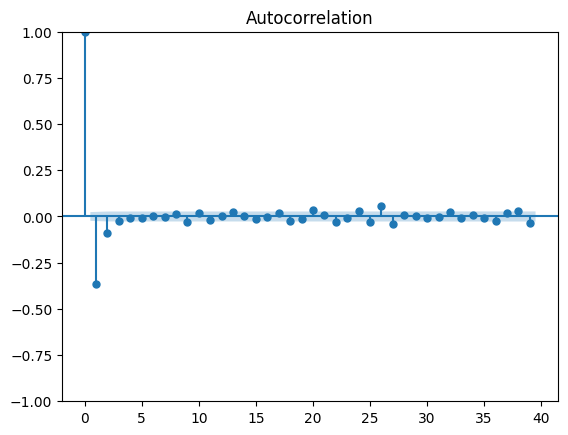

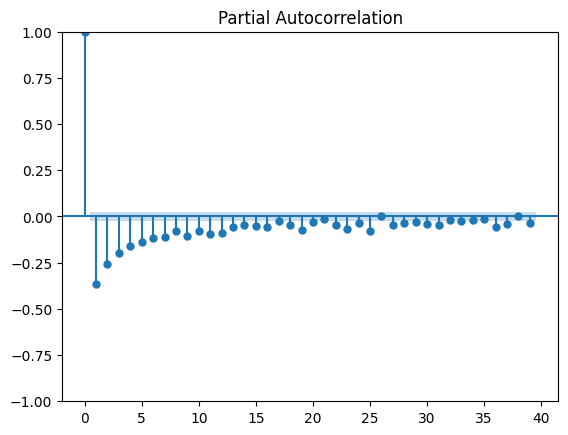

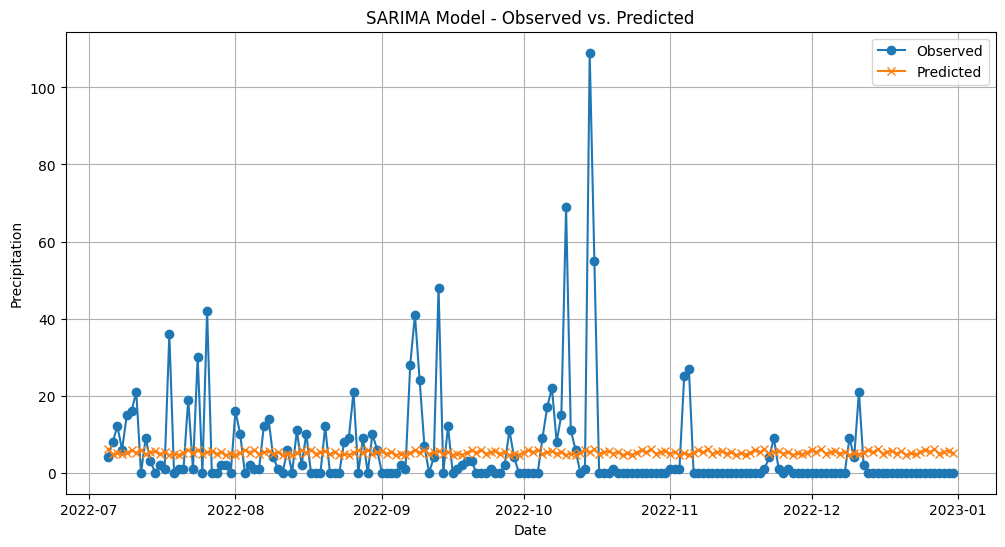

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Load the "noharshi" dataset
data = pd.read_csv('/content/noharshi.csv')

# Convert the 'datetime' column to a datetime object
data['datetime'] = pd.to_datetime(data['datetime'])

# Set 'datetime' column as the index
data.set_index('datetime', inplace=True)

# Define the target date for training
target_date = pd.to_datetime('2023-08-20')

data_target = data['precip']

# Split the data into training and testing sets
train_data = data_target.iloc[:-180]  # Use all except the last 60 days for training
test_data = data_target.iloc[-180:]   # Use the last 60 days for testing

# Differencing to make the data stationary
diff_train_data = train_data.diff().dropna()

# Perform ADF test on the differenced data to check stationarity
result_diff = adfuller(diff_train_data)
print('ADF Statistic after differencing:', result_diff[0])
print('p-value after differencing:', result_diff[1])

# Plot ACF and PACF for parameter selection
plot_acf(diff_train_data)
plot_pacf(diff_train_data)

# Fit the SARIMA model to the differenced training data
p, d, q = 1, 1, 1  # Example values, adjust based on your analysis
P, D, Q, S = 1, 1, 1, 12  # Example seasonal values, adjust as needed

sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_model_fit = sarima_model.fit()

# Forecast using the fitted SARIMA model
forecast = sarima_model_fit.get_forecast(steps=len(test_data))

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(test_data, forecast.predicted_mean)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print('RMSE:', rmse)

# Plot the observed vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Observed', marker='o')
plt.plot(test_data.index, forecast.predicted_mean, label='Predicted', marker='x')
plt.title('SARIMA Model - Observed vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50
211/211 [==============================] - 3s 6ms/step - loss: 0.0022
Epoch 2/50
211/211 [==============================] - 1s 5ms/step - loss: 0.0021
Epoch 3/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0021
Epoch 4/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0021
Epoch 5/50
211/211 [==============================] - 2s 9ms/step - loss: 0.0021
Epoch 6/50
211/211 [==============================] - 1s 7ms/step - loss: 0.0021
Epoch 7/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0021
Epoch 8/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0021
Epoch 9/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 10/50
211/211 [==============================] - 1s 5ms/step - loss: 0.0020
Epoch 11/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 12/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 13/50
211/211 [====

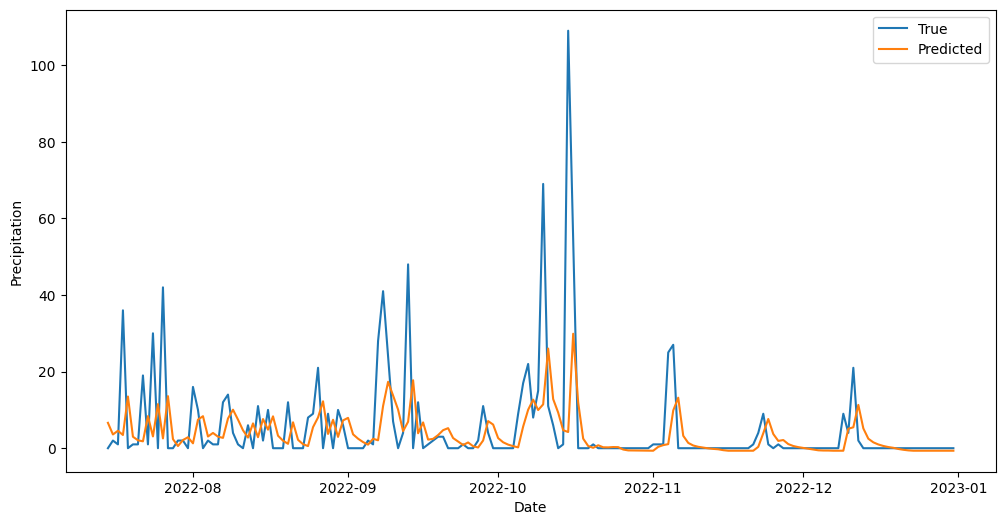

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the "noharshi" dataset
data = pd.read_csv('/content/nosravya.csv')

# Convert the 'datetime' column to a datetime object
data['datetime'] = pd.to_datetime(data['datetime'])

# Set 'datetime' column as the index
data.set_index('datetime', inplace=True)

# Define the target date for training
target_date = pd.to_datetime('2023-08-20')

data_target = data['precip']

# Split the data into training and testing sets
train_data = data_target.iloc[:-180]  # Use all except the last 60 days for training
test_data = data_target.iloc[-180:]   # Use the last 60 days for testing

# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(np.array(train_data).reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append((seq, label))
    return sequences

sequence_length = 10  # You can adjust this value
train_sequences = create_sequences(train_data_normalized, sequence_length)

X_train = np.array([seq for seq, label in train_sequences])
y_train = np.array([label for seq, label in train_sequences])

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Forecast using the trained model
test_data_normalized = scaler.transform(np.array(test_data).reshape(-1, 1))
test_sequences = create_sequences(test_data_normalized, sequence_length)

X_test = np.array([seq for seq, label in test_sequences])
y_test = np.array([label for seq, label in test_sequences])

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse normalize the predictions

# Calculate metrics
mae = mean_absolute_error(test_data.values[sequence_length:], predictions)
mse = mean_squared_error(test_data.values[sequence_length:], predictions)
r2 = r2_score(test_data.values[sequence_length:], predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[sequence_length:], test_data.values[sequence_length:], label='True')
plt.plot(test_data.index[sequence_length:], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend()
plt.show()


Epoch 1/50
211/211 [==============================] - 3s 6ms/step - loss: 0.0168
Epoch 2/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0033
Epoch 3/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0030
Epoch 4/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0028
Epoch 5/50
211/211 [==============================] - 2s 9ms/step - loss: 0.0026
Epoch 6/50
211/211 [==============================] - 2s 8ms/step - loss: 0.0024
Epoch 7/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0023
Epoch 8/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0022
Epoch 9/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0021
Epoch 10/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0021
Epoch 11/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0021
Epoch 12/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0021
Epoch 13/50
211/211 [====

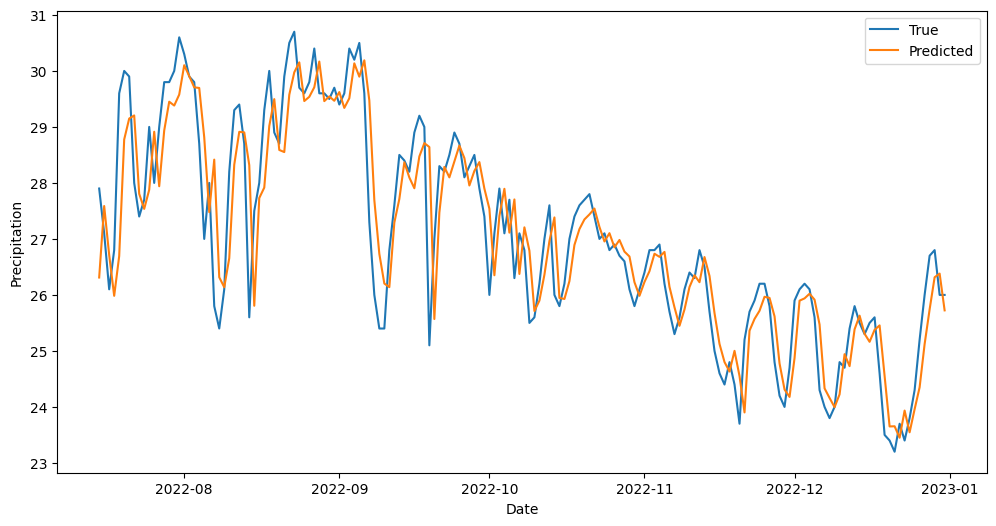

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the "noharshi" dataset
data = pd.read_csv('/content/nosravya.csv')

# Convert the 'datetime' column to a datetime object
data['datetime'] = pd.to_datetime(data['datetime'])

# Set 'datetime' column as the index
data.set_index('datetime', inplace=True)

# Define the target date for training
target_date = pd.to_datetime('2023-08-20')

data_target = data['temp']

# Split the data into training and testing sets
train_data = data_target.iloc[:-180]  # Use all except the last 60 days for training
test_data = data_target.iloc[-180:]   # Use the last 60 days for testing

# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(np.array(train_data).reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append((seq, label))
    return sequences

sequence_length = 10  # You can adjust this value
train_sequences = create_sequences(train_data_normalized, sequence_length)

X_train = np.array([seq for seq, label in train_sequences])
y_train = np.array([label for seq, label in train_sequences])

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Forecast using the trained model
test_data_normalized = scaler.transform(np.array(test_data).reshape(-1, 1))
test_sequences = create_sequences(test_data_normalized, sequence_length)

X_test = np.array([seq for seq, label in test_sequences])
y_test = np.array([label for seq, label in test_sequences])

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse normalize the predictions

# Calculate metrics
mae = mean_absolute_error(test_data.values[sequence_length:], predictions)
mse = mean_squared_error(test_data.values[sequence_length:], predictions)
r2 = r2_score(test_data.values[sequence_length:], predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[sequence_length:], test_data.values[sequence_length:], label='True')
plt.plot(test_data.index[sequence_length:], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('temperature')
plt.legend()
plt.show()

Epoch 1/50
211/211 [==============================] - 5s 10ms/step - loss: 0.0325
Epoch 2/50
211/211 [==============================] - 2s 9ms/step - loss: 0.0054
Epoch 3/50
211/211 [==============================] - 1s 7ms/step - loss: 0.0048
Epoch 4/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0043
Epoch 5/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0038
Epoch 6/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0036
Epoch 7/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0036
Epoch 8/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0035
Epoch 9/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0035
Epoch 10/50
211/211 [==============================] - 2s 7ms/step - loss: 0.0035
Epoch 11/50
211/211 [==============================] - 2s 10ms/step - loss: 0.0034
Epoch 12/50
211/211 [==============================] - 1s 6ms/step - loss: 0.0034
Epoch 13/50
211/211 [==

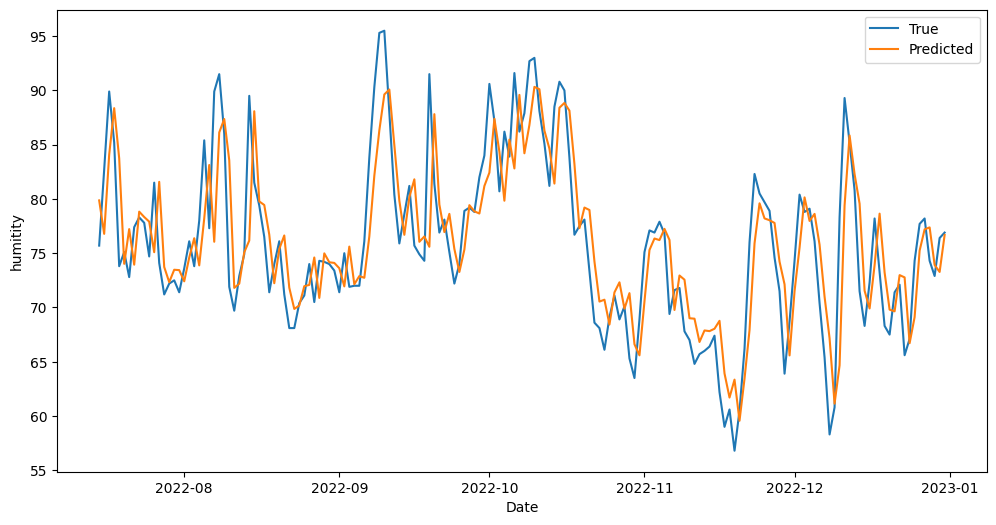

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the "noharshi" dataset
data = pd.read_csv('/content/nosravya.csv')

# Convert the 'datetime' column to a datetime object
data['datetime'] = pd.to_datetime(data['datetime'])

# Set 'datetime' column as the index
data.set_index('datetime', inplace=True)

# Define the target date for training
target_date = pd.to_datetime('2023-08-20')

data_target = data['humidity']

# Split the data into training and testing sets
train_data = data_target.iloc[:-180]  # Use all except the last 60 days for training
test_data = data_target.iloc[-180:]   # Use the last 60 days for testing

# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(np.array(train_data).reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append((seq, label))
    return sequences

sequence_length = 10  # You can adjust this value
train_sequences = create_sequences(train_data_normalized, sequence_length)

X_train = np.array([seq for seq, label in train_sequences])
y_train = np.array([label for seq, label in train_sequences])

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Forecast using the trained model
test_data_normalized = scaler.transform(np.array(test_data).reshape(-1, 1))
test_sequences = create_sequences(test_data_normalized, sequence_length)

X_test = np.array([seq for seq, label in test_sequences])
y_test = np.array([label for seq, label in test_sequences])

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse normalize the predictions

# Calculate metrics
mae = mean_absolute_error(test_data.values[sequence_length:], predictions)
mse = mean_squared_error(test_data.values[sequence_length:], predictions)
r2 = r2_score(test_data.values[sequence_length:], predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[sequence_length:], test_data.values[sequence_length:], label='True')
plt.plot(test_data.index[sequence_length:], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('humitity')
plt.legend()
plt.show()